## SF crime data analysis and modeling

### In this notebook, I will shoe how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). 
The first part of Homework is OLAP for scrime data analysis.
The second part is unsupervised learning for spatial data analysis.
The option part is the time series data analysis.
**Note**: you can download the small data (one month e.g. 2018-10) for debug, then download the data from 2013 to 2018 for testing and analysising.

In [3]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [4]:
#
#
#
#import urllib.request
#urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/sf_03_18.csv")
#dbutils.fs.mv("file:/tmp/sf_03_18.csv", "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv")
display(dbutils.fs.ls("dbfs:/laioffer/spark_hw1/data/"))
#
#
#
#
# https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD

path,name,size
dbfs:/laioffer/spark_hw1/data/sf_03_18.csv,sf_03_18.csv,544214906


In [5]:
data_path = "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv"
# use this file name later

In [6]:
# read data from the data storage
# please upload your data into databricks community at first. 

# use RDD
crime_data_lines = sc.textFile(data_path)
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
#header = df_crimes.first()
#print(header)

#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
#display(crimes.take(3))

#get the total number of data 
#print(crimes.count())


In [7]:
#get header
header = df_crimes.first()
print(header)

['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh', ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv', ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx', ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq', ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e', ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi', ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4']

In [8]:
#get the first line of data
display(crimes.take(3))

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34,8,2,9,28853,34,,1,,1,,,2,,,1,
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20,8,2,9,28853,19,,1,,1,,8,2,1,1,1,
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20,2,4,7,28859,19,13,,15,3,15,,2,,,3,


In [9]:
type(crimes)

Out[7]: pyspark.rdd.PipelinedRDD

In [10]:
#get the total number of data 
print(crimes.count())

2215024

### Solve  big data issues via Spark
approach 1: use RDD (not recommend)  
approach 2: use Dataframe, register the RDD to a dataframe  
approach 3: use SQL

In [12]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
#display(df_opt1)
df_opt1.show(10)
df_opt1.createOrReplaceTempView("sf_crime")

## helper function to transform the date, choose your way to do it. 
# 
# refer: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-functions-datetime.html
# 
# 
# from pyspark.sql.functions import to_date, to_timestamp, hour
# df_opt1 = df_opt1.withColumn('Date', to_date(df_opt1.OccurredOn, "MM/dd/yy"))
# df_opt1 = df_opt1.withColumn('Time', to_timestamp(df_opt1.OccurredOn, "MM/dd/yy HH:mm"))
# df_opt1 = df_opt1.withColumn('Hour', hour(df_opt1['Time']))
# df_opt1 = df_opt1.withColumn("DayOfWeek", date_format(df_opt1.Date, "EEEE"))

##
#from pyspark.sql.functions import col, udf
#from pyspark.sql.functions import expr
#from pyspark.sql.functions import from_unixtime

#date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
#month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())

#df = df_opt1.withColumn('month_year', month_func(col('Date')))\
#           .withColumn('Date_time', date_func(col('Date')))

##
# select Date, substring(Date,7) as Year, substring(Date,1,2) as Month from sf_crime


##
# from pyspark.sql.functions import *
# df_update = df_opt1.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy")) ##change datetype from string to date
# df_update.createOrReplaceTempView("sf_crime")
# crimeYearMonth = spark.sql("SELECT Year(Date) AS Year, Month(Date) AS Month, FROM sf_crime")

+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+---------------------+------------------------+----------------------------+----------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
IncidntNum| Category| Descript|DayOfWeek| Date| Time|PdDistrict| Resolution| Address| X| Y| Location| PdId|SF Find Neighborhoods|Current Police Districts|Current Supervisor Districts|Analysis Neighborhoods|:@computed_region_yftq_j783|:@computed_region_p5aj_wyqh|:@computed_region_rxqg_mtj9|:@computed_region_bh8s_q3mv|:@computed_region_fyvs_ahh9|:@computed_region_9dfj_4gjx|:@computed_region_n4xg_c4py|:@computed_region_4isq_27mq|:@computed_region_fcz8_est8|:@computed_region_pigm_ib2e|:@computed_region_9jxd_iqea|:@computed_region_6pnf_4xz7|:@computed_region_6ezc_tdp2|:@computed_region_h4ep_8xdi|:@computed_region_nqbw_i6c3|:@computed_region_2dwj_jsy4|
+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+---------------------+------------------------+----------------------------+----------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
 180362289| VEHICLE THEFT| STOLEN MOTORCYCLE| Tuesday|05/15/2018|10:30| SOUTHERN| NONE|700 Block of TEHA...|-122.41191202732877| 37.77520656149669|(37.7752065614966...|18036228907023| 32| 1| 10| 34| 8| 2| 9| 28853| 34| null| 1| null| 1| null| null| 2| null| null| 1| null|
 180360948| NON-CRIMINAL|AIDED CASE, MENTA...| Tuesday|05/15/2018|04:14| SOUTHERN| NONE|MARKET ST / SOUTH...|-122.41925789481357| 37.77514629165388|(37.7751462916538...|18036094864020| 32| 1| 10| 20| 8| 2| 9| 28853| 19| null| 1| null| 1| null| 8| 2| 1| 1| 1| null|
 180360879|OTHER OFFENSES| PAROLE VIOLATION| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087926150| 53| 3| 2| 20| 2| 4| 7| 28859| 19| 13| null| 15| 3| 15| null| 2| null| null| 3| null|
 180360879|OTHER OFFENSES|TRAFFIC VIOLATION...| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965010| 53| 3| 2| 20| 2| 4| 7| 28859| 19| 13| null| 15| 3| 15| null| 2| null| null| 3| null|
 180360879|OTHER OFFENSES| TRAFFIC VIOLATION| Tuesday|05/15/2018|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965015| 53| 3| 2| 20| 2| 4| 7| 28859| 19| 13| null| 15| 3| 15| null| 2| null| null| 3| null|
 180360829|OTHER OFFENSES|DRIVERS LICENSE, ...| Tuesday|05/15/2018|01:27| MISSION| NONE|700 Block of SHOT...|-122.41561725232026| 37.75641376904809|(37.7564137690480...|18036082965016| 53| 3| 2| 20| 2| 4| 7| 28859| 19| null| null| null| 3| null| null| 2| null| null| 3| null|
 180360835| ROBBERY|ROBBERY, BODILY F...| Tuesday|05/15/2018|01:25| SOUTHERN|ARREST, BOOKED| 0 Block of 6TH ST|-122.41004163181597|37.781953653725715|(37.7819536537257...|18036083503074| 32| 5| 10| 34| 14| 2| 9| 288

#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [14]:
q1_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [15]:
type(q1_result)

Out[11]: pyspark.sql.dataframe.DataFrame

In [16]:
#Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [17]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

crimes_pd_df = crimeCategory.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

display(crimes_pd_df)


category,Count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [18]:
type(crimes_pd_df)

Out[14]: pandas.core.frame.DataFrame

In [19]:
# Because the categories are too many to see clearly for visualization, I use OTHER to sum up all of the categories smaller than 5000.
# Find and sum up the categories, which is smaller than 5000.
amount_of_under_5000 = crimes_pd_df.loc[crimes_pd_df['Count']< 5000].sum(axis = 0)[-1]
amount_of_under_5000

Out[15]: 23678

In [20]:
# Find the index of all of the categories, the count is smaller than 5000.
crimes_pd_df[crimes_pd_df['Count']< 5000].index
# Drop the rows
crimes_pd_df_count_larger_than_5000 = crimes_pd_df.drop(crimes_pd_df[crimes_pd_df['Count']< 5000].index)
crimes_pd_df_count_larger_than_5000

,category,Count
0,LARCENY/THEFT,480448
1,OTHER OFFENSES,309358
2,NON-CRIMINAL,238323
3,ASSAULT,194694
4,VEHICLE THEFT,126602
5,DRUG/NARCOTIC,119628
6,VANDALISM,116059
7,WARRANTS,101379
8,BURGLARY,91543
9,SUSPICIOUS OCC,80444


In [21]:
# Create the new category 'OTHER' to store the amount of all of the categories, which is under 5000
crimes_pd_df_count_larger_than_5000 = crimes_pd_df_count_larger_than_5000.append({'category': 'OTHERS', 'Count': amount_of_under_5000},ignore_index=True)
crimes_pd_df_count_larger_than_5000

,category,Count
0,LARCENY/THEFT,480448
1,OTHER OFFENSES,309358
2,NON-CRIMINAL,238323
3,ASSAULT,194694
4,VEHICLE THEFT,126602
5,DRUG/NARCOTIC,119628
6,VANDALISM,116059
7,WARRANTS,101379
8,BURGLARY,91543
9,SUSPICIOUS OCC,80444


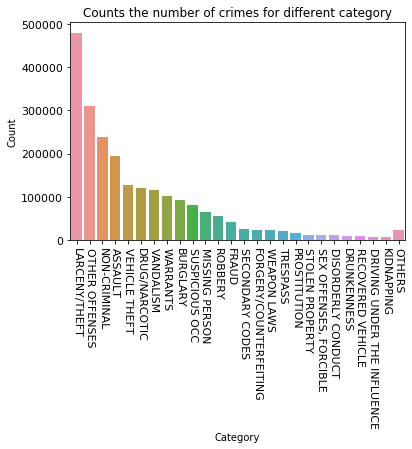

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

bar, ax0 = plt.subplots()
ax0 = sns.barplot(x='category',y='Count',
                 data=crimes_pd_df_count_larger_than_5000)
ax0.set_title('Counts the number of crimes for different category')
ax0.set_xlabel('Category')
plt.xticks(rotation=-90) #important!
ax0.set_ylabel('Count')
plt.tick_params(labelsize=11) # important! let the categories see more clear
display(bar)


#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [24]:
q2_result = df_opt1.groupBy('PdDistrict').count().orderBy('count', ascending=False)
display(q2_result)

PdDistrict,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


In [25]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

crimes_district_df = q2_result.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

display(crimes_district_df)

PdDistrict,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


In [26]:
type(crimes_district_df)

Out[21]: pandas.core.frame.DataFrame

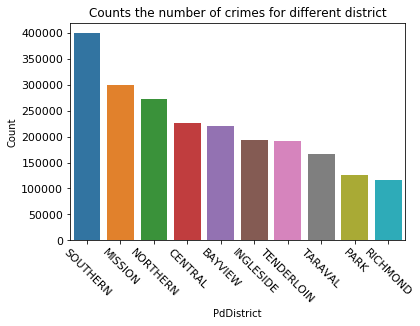

In [27]:
bar, ax = plt.subplots()
ax = sns.barplot(x='PdDistrict',y='count',
                 data=crimes_district_df)
ax.set_title('Counts the number of crimes for different district')
ax.set_xlabel('PdDistrict')
ax.set_ylabel('Count')
plt.xticks(rotation=-45) #important!
plt.tick_params(labelsize=11) #important!
display(bar)
# I do not know how to show the categories clearly in y label. Could you give me some feedback? Thanks so much Mike. 

#### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown".   
hints: SF downtown is defiend  via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can define a cicle with center as well. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

In [29]:
# I use sql trying to slove this problem. First, I went to Google map to get X and Y of downtown of SF. Then, I use query to get the count from each sunday's activities.
# Because the data volume is too much, I only select the latest year "2018".

each_sunday_2018 = spark.sql ("SELECT Date, dayOfWeek, count(IncidntNum) as IncidntNum \
                         FROM sf_crime \
                         where dayOfWeek = 'Sunday' and X between -122.430513 and -122.409229 and Y between 37.774586 and 37.780999 \
                         and Date LIKE '%2018' \
                         GROUP BY 1 ,2\
                         ORDER by IncidntNum")
display(each_sunday_2018)

Date,dayOfWeek,IncidntNum
05/06/2018,Sunday,8
05/13/2018,Sunday,10
02/25/2018,Sunday,11
04/22/2018,Sunday,14
02/18/2018,Sunday,15
02/11/2018,Sunday,15
01/21/2018,Sunday,16
04/15/2018,Sunday,16
02/04/2018,Sunday,17
03/18/2018,Sunday,17


In [30]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

each_sunday_2018_df = each_sunday_2018.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

display(each_sunday_2018_df)

Date,dayOfWeek,IncidntNum
05/06/2018,Sunday,8
05/13/2018,Sunday,10
02/25/2018,Sunday,11
04/22/2018,Sunday,14
02/11/2018,Sunday,15
02/18/2018,Sunday,15
04/15/2018,Sunday,16
01/21/2018,Sunday,16
03/18/2018,Sunday,17
02/04/2018,Sunday,17


In [31]:
type(each_sunday_2018_df)

Out[25]: pandas.core.frame.DataFrame

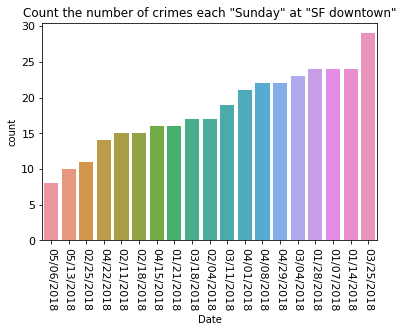

In [32]:
bar, ax = plt.subplots()
ax = sns.barplot(x='Date',y='IncidntNum',
                 data=each_sunday_2018_df)
ax.set_title('Count the number of crimes each "Sunday" at "SF downtown"')
ax.set_xlabel('Date')
ax.set_ylabel('count')
plt.xticks(rotation=-90) #important!
plt.tick_params(labelsize=11) #important!

display(bar)

#### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [34]:
# The day column should be sperated to month, day and year to solve this problem. 

import pyspark.sql.functions as func

split_date=func.split(df_opt1['Date'], '/') 
data_with_month_day_year= df_opt1.withColumn('Month', split_date.getItem(0)).withColumn('Day', split_date.getItem(1)).withColumn('Year', split_date.getItem(2))
display(data_with_month_day_year)
data_with_month_day_year.createOrReplaceTempView("sf_crime_v2")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,:@computed_region_yftq_j783,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_bh8s_q3mv,:@computed_region_fyvs_ahh9,:@computed_region_9dfj_4gjx,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4,Month,Day,Year
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34,8,2,9,28853,34,null,1,null,1,null,null,2,null,null,1,null,05,15,2018
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20,8,2,9,28853,19,null,1,null,1,null,8,2,1,1,1,null,05,15,2018
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,05,15,2018
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,05,15,2018
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,05,15,2018
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016,53,3,2,20,2,4,7,28859,19,null,null,null,3,null,null,2,null,null,3,null,05,15,2018
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074,32,5,10,34,14,2,9,28853,34,17,1,18,1,18,7,2,1,1,1,null,05,15,2018
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710,32,5,10,34,14,2,9,28853,34,17,1,18,1,18,7,2,1,1,1,null,05,15,2018
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030,25,7,11,3,15,5,11,29492,9,22,null,24,null,25,null,1,null,null,null,null,05,15,2018
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050,25,7,11,3,15,5,11,29492,9,22,null,24,null,25,null,1,null,null,null,null,05,15,2018


In [35]:
type(data_with_month_day_year)

Out[28]: pyspark.sql.dataframe.DataFrame

In [36]:
# the data of 2015

q4_2015 = data_with_month_day_year[data_with_month_day_year['Year']==2015].groupBy('month').count().orderBy('month', ascending=True)
display(q4_2015)

month,count
01,13606
02,12329
03,13929
04,12959
05,13729
06,13304
07,13365
08,13730
09,12896
10,13147


In [37]:
# the data of 2016

q4_2016 = data_with_month_day_year[data_with_month_day_year['Year']==2016].groupBy('month').count().orderBy('month', ascending=True)
display(q4_2016)

month,count
01,12967
02,12106
03,12380
04,12328
05,12732
06,12094
07,12191
08,12471
09,12499
10,13388


In [38]:
# the data of 2017

q4_2017 = data_with_month_day_year[data_with_month_day_year['Year']==2017].groupBy('month').count().orderBy('month', ascending=True)
display(q4_2017)

month,count
01,13084
02,12192
03,13711
04,12941
05,13267
06,12605
07,13171
08,12872
09,12684
10,13355


In [39]:
# the data of 2018

q4_2018 = data_with_month_day_year[data_with_month_day_year['Year']==2018].groupBy('month').count().orderBy('month', ascending=True)
display(q4_2018)

month,count
01,12031
02,9947
03,10740
04,10306
05,3644


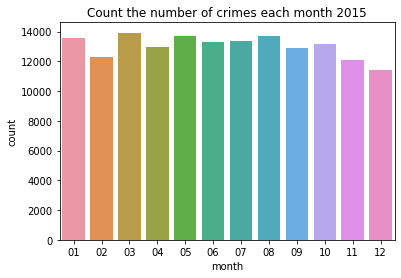

In [40]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe.
df_q4_2015 = q4_2015.toPandas()

# visualizing
bar, ax = plt.subplots()
ax = sns.barplot(x='month',y='count',
                 data=df_q4_2015)
ax.set_title('Count the number of crimes each month 2015')
ax.set_xlabel('month')
ax.set_ylabel('count')
display(bar)

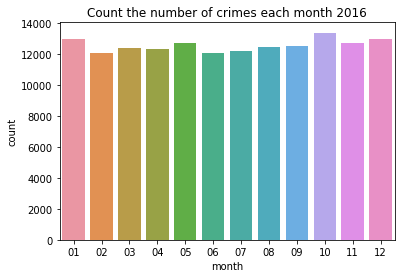

In [41]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe.
df_q4_2016 = q4_2016.toPandas()

# visualizing
bar, ax = plt.subplots()
ax = sns.barplot(x='month',y='count',
                 data=df_q4_2016)
ax.set_title('Count the number of crimes each month 2016')
ax.set_xlabel('month')
ax.set_ylabel('count')
display(bar)

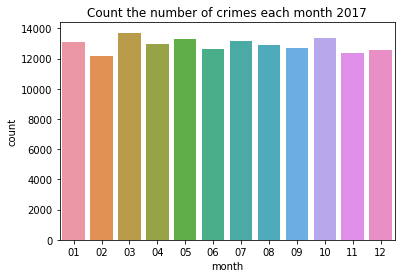

In [42]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe.
df_q4_2017 = q4_2017.toPandas()

# visualizing
bar, ax = plt.subplots()
ax = sns.barplot(x='month',y='count',
                 data=df_q4_2017)
ax.set_title('Count the number of crimes each month 2017')
ax.set_xlabel('month')
ax.set_ylabel('count')
display(bar)

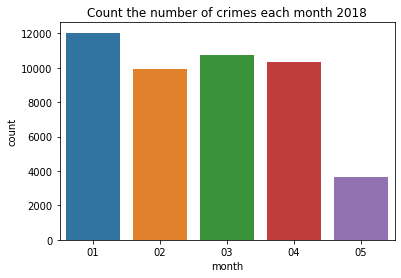

In [43]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe.
df_q4_2018 = q4_2018.toPandas()

# visualizing
bar, ax = plt.subplots()
ax = sns.barplot(x='month',y='count',
                 data=df_q4_2018)
ax.set_title('Count the number of crimes each month 2018')
ax.set_xlabel('month')
ax.set_ylabel('count')
display(bar)

In [44]:
count_4_years = spark.sql("SELECT month , count(IncidntNum) FROM sf_crime_v2 where year between 2015 and 2018 GROUP BY 1 ORDER BY month")
display(count_4_years)

month,count(IncidntNum)
01,51688
02,46574
03,50760
04,48534
05,43372
06,38003
07,38727
08,39073
09,38079
10,39890


In [45]:
gg = spark.sql("SELECT year, month , count(IncidntNum) FROM sf_crime_v2 where month between 1 and 5 and year between 2015 and 2018 GROUP BY 1,2 ORDER BY 3")
display(gg)

year,month,count(IncidntNum)
2018,05,3644
2018,02,9947
2018,04,10306
2018,03,10740
2018,01,12031
2016,02,12106
2017,02,12192
2016,04,12328
2015,02,12329
2016,03,12380


Analysis:
For the data from 2018, the count of crime is largely decreasing from the past 3 years even though we have just 5 months of information. If we see the count of each month in 4 years, it would be hard to see the difference. It is nothing difference between 2015 and 2017 because the count is so close.

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give your travel suggestion to visit SF.

In [48]:
# The time column should be sperated to hour and minute to solve this problem. 

#import pyspark.sql.functions as func

split_time=func.split(df_opt1['Time'], ':') 
data_with_hour_minute= df_opt1.withColumn('hour', split_time.getItem(0)).withColumn('minute', split_time.getItem(1))
display(data_with_hour_minute)
data_with_hour_minute.createOrReplaceTempView("sf_crime_v3")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,:@computed_region_yftq_j783,:@computed_region_p5aj_wyqh,:@computed_region_rxqg_mtj9,:@computed_region_bh8s_q3mv,:@computed_region_fyvs_ahh9,:@computed_region_9dfj_4gjx,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4,hour,minute
180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.41191202732877,37.77520656149669,"(37.77520656149669, -122.41191202732877)",18036228907023,32,1,10,34,8,2,9,28853,34,null,1,null,1,null,null,2,null,null,1,null,10,30
180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.41925789481357,37.77514629165388,"(37.77514629165388, -122.41925789481357)",18036094864020,32,1,10,20,8,2,9,28853,19,null,1,null,1,null,8,2,1,1,1,null,04,14
180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087926150,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,02,01
180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965010,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,02,01
180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.41781255878655,37.757100579642824,"(37.757100579642824, -122.41781255878655)",18036087965015,53,3,2,20,2,4,7,28859,19,13,null,15,3,15,null,2,null,null,3,null,02,01
180360829,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Tuesday,05/15/2018,01:27,MISSION,NONE,700 Block of SHOTWELL ST,-122.41561725232026,37.75641376904809,"(37.75641376904809, -122.41561725232026)",18036082965016,53,3,2,20,2,4,7,28859,19,null,null,null,3,null,null,2,null,null,3,null,01,27
180360835,ROBBERY,"ROBBERY, BODILY FORCE",Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083503074,32,5,10,34,14,2,9,28853,34,17,1,18,1,18,7,2,1,1,1,null,01,25
180360835,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Tuesday,05/15/2018,01:25,SOUTHERN,"ARREST, BOOKED",0 Block of 6TH ST,-122.41004163181597,37.781953653725715,"(37.781953653725715, -122.41004163181597)",18036083516710,32,5,10,34,14,2,9,28853,34,17,1,18,1,18,7,2,1,1,1,null,01,25
180360794,LIQUOR LAWS,MISCELLANEOUS LIQOUR LAW VIOLATION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079417030,25,7,11,3,15,5,11,29492,9,22,null,24,null,25,null,1,null,null,null,null,00,19
180360794,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Tuesday,05/15/2018,00:19,PARK,"ARREST, BOOKED",1500 Block of HAIGHT ST,-122.44776112231955,37.76984648754153,"(37.76984648754153, -122.44776112231955)",18036079462050,25,7,11,3,15,5,11,29492,9,22,null,24,null,25,null,1,null,null,null,null,00,19


In [49]:
date_2015_12_15 = spark.sql("SELECT hour, count(IncidntNum) FROM sf_crime_v3 where date = '12/15/2015' GROUP BY 1 ORDER BY 2 desc ")
display(date_2015_12_15)

hour,count(IncidntNum)
12,35
16,31
14,27
10,26
19,26
17,18
18,18
11,15
00,15
15,14


In [50]:
date_2016_12_15 = spark.sql("SELECT hour, count(IncidntNum) FROM sf_crime_v3 where date = '12/15/2016' GROUP BY 1  ORDER BY 2 desc ")
display(date_2016_12_15)

hour,count(IncidntNum)
18,38
19,31
12,29
20,27
08,24
09,23
22,22
00,22
17,20
14,19


In [51]:
date_2017_12_15 = spark.sql("SELECT hour, count(IncidntNum) FROM sf_crime_v3 where date = '12/15/2017' GROUP BY 1  ORDER BY 2 desc ")
display(date_2017_12_15)

hour,count(IncidntNum)
22,37
19,31
16,31
00,30
18,29
17,28
23,28
10,27
15,27
11,26


Analysis: From the 3 days of information, the safest time is in the morning in SF. However, the most dangerous time is in the afternoon in SF.

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [54]:
#(1) Step1: Find out the top-3 danger disrict

q6_result = df_opt1.groupBy('PdDistrict').count().orderBy('count', ascending=False).head(3)
display(q6_result)

PdDistrict,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713


In [55]:
#(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1
#in SOUTHERN

q6_SOUTHERN = data_with_hour_minute[data_with_hour_minute['PdDistrict']== 'SOUTHERN'].groupBy('category', 'hour').count().orderBy('count',ascending=False)
display(q6_SOUTHERN)

category,hour,count
LARCENY/THEFT,18,9633
LARCENY/THEFT,19,9198
LARCENY/THEFT,17,7927
LARCENY/THEFT,20,7414
LARCENY/THEFT,16,6741
LARCENY/THEFT,12,6451
LARCENY/THEFT,15,6377
LARCENY/THEFT,14,6255
LARCENY/THEFT,13,6171
LARCENY/THEFT,22,5963


In [56]:
#in MISSION

q6_MISSION = data_with_hour_minute[data_with_hour_minute['PdDistrict']== 'MISSION'].groupBy('category', 'hour').count().orderBy('count',ascending=False)
display(q6_MISSION)

category,hour,count
LARCENY/THEFT,18,3627
LARCENY/THEFT,19,3481
LARCENY/THEFT,20,3341
LARCENY/THEFT,23,3179
LARCENY/THEFT,22,3126
OTHER OFFENSES,12,3091
LARCENY/THEFT,21,3007
OTHER OFFENSES,17,2935
LARCENY/THEFT,17,2887
OTHER OFFENSES,16,2858


In [57]:
#in NORTHERN

q6_NORTHERN = data_with_hour_minute[data_with_hour_minute['PdDistrict']== 'NORTHERN'].groupBy('category', 'hour').count().orderBy('count',ascending=False)
display(q6_NORTHERN)

category,hour,count
LARCENY/THEFT,19,6819
LARCENY/THEFT,18,6724
LARCENY/THEFT,20,5903
LARCENY/THEFT,17,5196
LARCENY/THEFT,21,4952
LARCENY/THEFT,22,4729
LARCENY/THEFT,16,4409
LARCENY/THEFT,23,4309
LARCENY/THEFT,12,4206
LARCENY/THEFT,15,4104


Analysis: in these top 3 areas (Southern, Northern, and Mission), police officers should be more careful the category of larceny/theft after 12 pm because most of the crimes of this kind would be happening from the record.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [60]:
q7 = df_opt1.groupBy('Category', 'Resolution').count().orderBy('Category')
display(q7)

Category,Resolution,count
ARSON,NOT PROSECUTED,3
ARSON,PROSECUTED BY OUTSIDE AGENCY,3
ARSON,PSYCHOPATHIC CASE,17
ARSON,NONE,3174
ARSON,PROSECUTED FOR LESSER OFFENSE,1
ARSON,JUVENILE CITED,9
ARSON,JUVENILE ADMONISHED,9
ARSON,COMPLAINANT REFUSES TO PROSECUTE,3
ARSON,"ARREST, CITED",17
ARSON,EXCEPTIONAL CLEARANCE,2


In [61]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

q7_1 = q7.withColumn('percentage', col('count')*100/sum('count').over(Window.partitionBy('Category')))
q7_2 = q7_1.withColumn('percentage', col('percentage'))
q7_res = q7_2.filter(q7_2['Resolution'] == 'NONE')
display(q7_res)

Category,Resolution,count,percentage
ARSON,NONE,3174,80.74281353345205
ASSAULT,NONE,113747,58.42347478607456
BAD CHECKS,NONE,744,80.43243243243244
BRIBERY,NONE,338,41.57441574415744
BURGLARY,NONE,76653,83.7344198901063
DISORDERLY CONDUCT,NONE,3458,34.44223107569721
DRIVING UNDER THE INFLUENCE,NONE,317,5.58885754583921
DRUG/NARCOTIC,NONE,10271,8.58578259270405
DRUNKENNESS,NONE,1725,17.55546509261144
EMBEZZLEMENT,NONE,2147,71.85408299866131


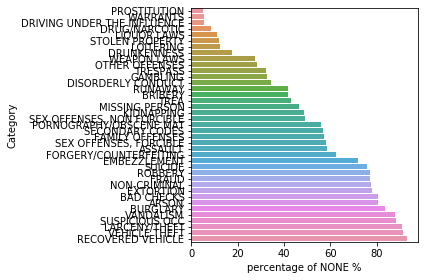

In [62]:
q7_res2 = q7_res.select(col('Category'), col('percentage').alias('percentage of NONE %')).orderBy('percentage of NONE %', ascending=True)
qq7 = q7_res2.toPandas()
fig, axes = plt.subplots(1,1)
sb.barplot(x="percentage of NONE %", y="Category",data=qq7,ax=axes)
plt.tight_layout()
display(fig.show())

#### Q8 question (Apply Spark ML clustering for spatial data analysis)
Extra: visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)  
You can refer Spark ML Kmeans a example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [64]:
df_q8 = df_opt1.select(['IncidntNum', 'X', 'Y'])
# df_q8 = df_q8.withColumn("prediction", lit(0))
display(df_q8)

IncidntNum,X,Y
180362289,-122.41191202732877,37.77520656149669
180360948,-122.41925789481357,37.77514629165388
180360879,-122.41781255878655,37.757100579642824
180360879,-122.41781255878655,37.757100579642824
180360879,-122.41781255878655,37.757100579642824
180360829,-122.41561725232026,37.75641376904809
180360835,-122.41004163181597,37.781953653725715
180360835,-122.41004163181597,37.781953653725715
180360794,-122.44776112231955,37.76984648754153
180360794,-122.44776112231955,37.76984648754153


In [65]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

features_col = ['X', 'Y']

for col in df_q8.columns:
  if col in features_col:
    df_q8 = df_q8.withColumn(col, df_q8[col].cast('double'))
    
    
vecAssembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='features')
df_to_kmeans = vecAssembler.transform(q8_df).select('IncidntNum', 'features')

In [66]:
# elbow method to get the best K
# it tooks time so long...


#cost = np.zeros(20)
#for k in range(2,20):
#  kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
#  model = kmeans.fit(df_to_kmeans.sample(False, 0.1, seed=42))
#  cost[k] = model.computeCost(df_to_kmeans)
  
#fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#ax.plot(range(2,20), cost[2:20])
#ax.set_xlabel('K')
#ax.set_ylabel('cost')
#display(fig.show())


In [67]:
#K = 8

kmeans = KMeans().setK(8).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_to_kmeans)
centers = model.clusterCenters()

In [68]:
trains = model.transform(df_to_kmeans).select('IncidntNum', 'features', 'prediction')
display(trains.take(3))

IncidntNum,features,prediction
180362289,"List(1, 2, List(), List(-122.41191202732877, 37.77520656149669))",2
180360948,"List(1, 2, List(), List(-122.41925789481357, 37.77514629165388))",2
180360879,"List(1, 2, List(), List(-122.41781255878655, 37.757100579642824))",5


In [69]:
res = df_q8.join(trains, trains.IncidntNum == df_q8.IncidntNum).drop(trains.IncidntNum)
res1 = res.drop('features', 'IncidntNum')
res1 = res1.withColumn("X", res1.X.cast('double'))
res1 = res1.withColumn("Y", res1.Y.cast('double'))
display(res1)

X,Y,prediction
-122.429042228263,37.7818456494851,7
-122.413259498719,37.7829514828801,2
-122.420004126989,37.7829415360009,7
-122.403404791479,37.775420706711,2
-122.466026150018,37.7409281890178,3
-122.406338412693,37.7530042877269,5
-122.43650761995,37.7770672269612,0
-122.41671364157,37.7441930915845,5
-122.41671364157,37.7441930915845,5
-122.41671364157,37.7441930915845,5


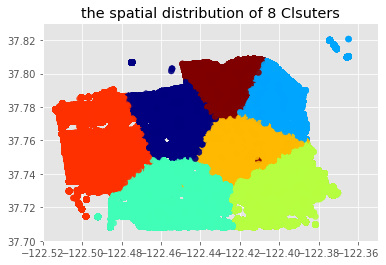

In [70]:
res2 = res1.toPandas()
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(res2['X'], res2['Y'], c=(res2['prediction']),cmap=plt.cm.jet, alpha=0.9)
ax.set_xlim([-122.52,-122.35])
ax.set_ylim([37.7,37.83])
ax.set_title("the spatial distribution of 8 Clsuters")
display()

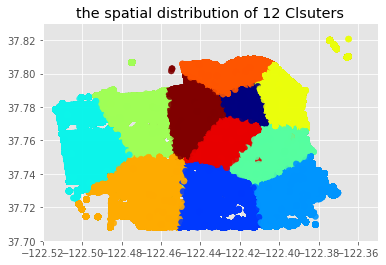

In [71]:
# k = 12

kmeans = KMeans().setK(12).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_to_kmeans)
centers = model.clusterCenters()

trains = model.transform(df_to_kmeans).select('IncidntNum', 'features', 'prediction')

res = df_q8.join(trains, trains.IncidntNum == df_q8.IncidntNum).drop(trains.IncidntNum)
res1 = res.drop('features', 'IncidntNum')
res1 = res1.withColumn("X", res1.X.cast('double'))
res1 = res1.withColumn("Y", res1.Y.cast('double'))


res2 = res1.toPandas()
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(res2['X'], res2['Y'], c=(res2['prediction']),cmap=plt.cm.jet, alpha=0.9)
ax.set_xlim([-122.52,-122.35])
ax.set_ylim([37.7,37.83])
ax.set_title("the spatial distribution of 12 Clsuters")
display()

### Time series analysis
This analysis is not based on Spark, and only based on Pandas Time Series package.

In [73]:
import pyspark.sql.functions as f
df_with_year =  df_opt1.withColumn('years',f.year(f.to_timestamp('Date', 'mm/dd/yyyy')))

In [74]:
df_with_year.createOrReplaceTempView("df_with_year")
df_2017 = spark.sql("SELECT Date, count(Category) as THEFT  FROM df_with_year WHERE years in ('2017') and Category == 'LARCENY/THEFT'\
                       GROUP BY Date ORDER BY Date")
df_2018 = spark.sql("SELECT Date, count(Category)  FROM df_with_year WHERE years in ('2018') and Category == 'LARCENY/THEFT'\
                       GROUP BY Date ORDER BY Date")



In [75]:
display(df_2017)

Date,THEFT
01/01/2017,129
01/02/2017,86
01/03/2017,108
01/04/2017,121
01/05/2017,113
01/06/2017,133
01/07/2017,135
01/08/2017,112
01/09/2017,98
01/10/2017,123


In [76]:
display(df_2018)

Date,count(Category)
01/01/2018,130
01/02/2018,107
01/03/2018,141
01/04/2018,136
01/05/2018,129
01/06/2018,131
01/07/2018,120
01/08/2018,127
01/09/2018,127
01/10/2018,101


In [77]:
from_2015_to_2017 = spark.sql("SELECT * from df_with_year where years in('2015','2016','2017') and Category == 'LARCENY/THEFT'")
only_2018 = spark.sql("SELECT * from df_with_year where years in('2018') and Category == 'LARCENY/THEFT'")

In [78]:
from_2015_to_2017_with_count = from_2015_to_2017.groupBy('Date').count().orderBy('Date').toPandas()
only_2018_with_count = only_2018.groupBy('Date').count().orderBy('Date').toPandas()

In [79]:
# Perform Augmented Dickey-Fuller test to test for a unit root
from statsmodels.tsa.stattools import adfuller
adfuller(from_2015_to_2017_with_count['count'])[1]

Out[94]: 0.0006140326882570473

### Conclusion

Analysis: I use both dataframe and spark SQL to solve problems. The report analysis the SF crime report and get some information via OLAP like what is the top 3 most dangerous district then visualizing by using matplotlib. Visualization is one of the most important parts of the analysis because the report should be readable from people who have no data analysis background. The trend will be showing from the work and the police officers can get useful information to increase efficiency.

1. SF crime(2003 to 2018) dataset with a size of over 500 million rows by descriptively exploring trends and information contained in the SF.


2. Insights are drawn so that the analysis can help the SF government and police department develop tactics and adjust problematic measures to better control criminal activities.

3. Larceny/Theft is the most criminal activities happened in 2003 - 2018.

4. The district 'Southern' , 'Northern', 'Mission' are the three most dangerous districts. 


5. There are many crime activities on Sundays in the downtown area, I suggest visitors should avoid going there.